In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler
# from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
#                           cross_val_multiscore, LinearModel,
#                           Vectorizer) #Scaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC


# Read MNE sample data

In [2]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                     baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right


Opening raw data file /Users/Maryam/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Setting up band-pass filter from 2 - 20 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 991 samples (1.650 sec) selected
320 events found
Event IDs: [ 1  2  3  4  5 32]
145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 145 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch base

# Autocorrelation

In [5]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

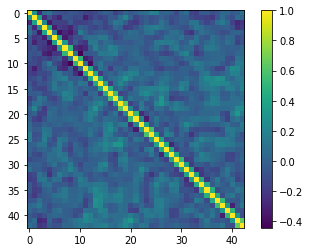

In [6]:
dt = np.mean(epochs._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_r = generate_correlation_map(x1, x1)
plt.imshow(map_r)
plt.colorbar()
     

In [7]:
map_r

array([[ 1.        ,  0.29449632, -0.28523236, ..., -0.03239727,
        -0.01359584,  0.07040777],
       [ 0.29449632,  1.        ,  0.39504845, ..., -0.0896712 ,
         0.06774167,  0.0140666 ],
       [-0.28523236,  0.39504845,  1.        , ..., -0.15510752,
        -0.28072097, -0.21556345],
       ...,
       [-0.03239727, -0.0896712 , -0.15510752, ...,  1.        ,
         0.32318334, -0.10509481],
       [-0.01359584,  0.06774167, -0.28072097, ...,  0.32318334,
         1.        ,  0.64161329],
       [ 0.07040777,  0.0140666 , -0.21556345, ..., -0.10509481,
         0.64161329,  1.        ]])

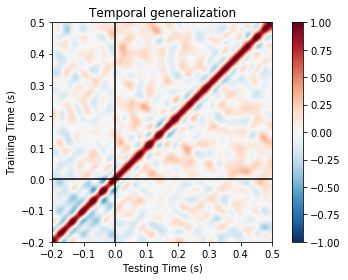

In [9]:
fig, ax = plt.subplots(1, 1)
plt.tight_layout()
im = ax.imshow(map_r, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0 , -1]], vmin=-1, vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Conclusion
The result does not seem similar to the temporal generalization matrix for this data